# Lesson 18: 

## SGD 

* First part of lesson goes through SGD, Momentum, RMSProp, Adam and Adam with annealing using a spreadsheet (graddesc.xlsm). 

* Adam works so much better it is quite suprising to me. After one or two runs you have to lower the learnign rate to keep it from bouncing around.

* Adam with annealing attempts to reduce the learning rate as the training progresses.
    * Keeps track of lowest squared gradient.
    *  If the current squared gradient is more than 1/2 the lowest, then it reduces the learning rate by a factor of 4.
    * This was implemented in VBA code in the spreadsheet. Works quite well! 


### Accelerated SGD 

* Notebook #12, same as last time but now up to the Schedulers section

In [1]:
import torch
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from minai.datasets import *
from minai.conv import *
from minai.learner import *
from minai.activations import *
from minai.init import *

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [2]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

Jeremy makes the point that we already know how to modify the learning rate, we did this with the learning rate finder. So we are not going to reimplement the schedulers from scratch, instead use the predified schedulers in PyTorch.

In [3]:
# lets see whats available, looking only ot stuff with CamelCase
' '.join([o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower()])

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

Let's experiment with Consine Annealing..  but first lets see whats in the pytorch optimizer so we can figure out how to get these schedulers working

In [3]:
# note: The devicecb is required. This seems like a bug in our code. We should default to
# CPU or something.
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=0.01, cbs = [DeviceCB(), SingleBatchCB()])
learn.fit(1) # need to run at least one epoch to get the optimizer
opt = learn.opt
opt

# at 27 minutes only

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

The optimizer repr gives you the configuration of the optimzer in a paramter group.  
The optimzer also has a state dict that contains the state of the optimizer (and the current parameters of the model. )

In [4]:
param = next(iter(learn.model.parameters()))

[Parameters](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) wrap the tensor (and are a special  kind of tensor)

In [5]:
st = opt.state[param] # this must look up the state of the parameter object by its hash (i.e. id)? I.e. the parameter object, even though the values can change.

In [6]:
# state of the optimizet is stored this way.. not as attributes as we did. 
st

{'momentum_buffer': None}

Optimizer parameters are stored in groups.  We will see later that this is useful for different learning rates for different layers (for example)

In [7]:
list(opt.param_groups[0])

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable',
 'fused']

Ok lets look at at a cosine annealing scheduler

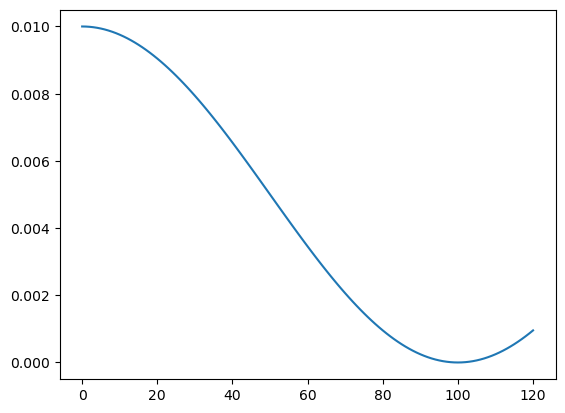

In [8]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100) #  Second argument is T_max, the number of iterations to go from the initial lr to the final lr, which defaults to 0.

# Plot it
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for _ in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

sched_lrs(sched, 120)

### Schedular call back. 

This will use a schedular to change the learning rate using a callback in our learner.

In [9]:

class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()

# if you   want learning rates to change after each batch, you can use the following
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

In [10]:
# A callback that can be used to record the learning rate among other things in the first parameter group

class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

# for recording the learning rate, as an example
def _lr(cb): return cb.pg['lr']

In [11]:
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

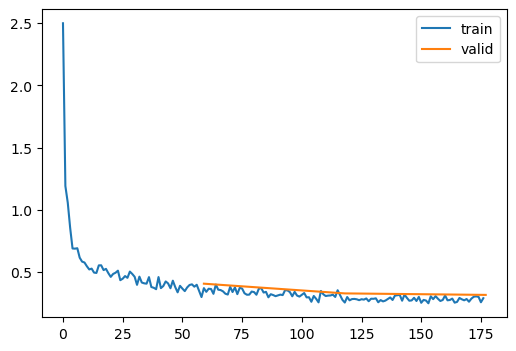

In [12]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)  # here is where _lr is used
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

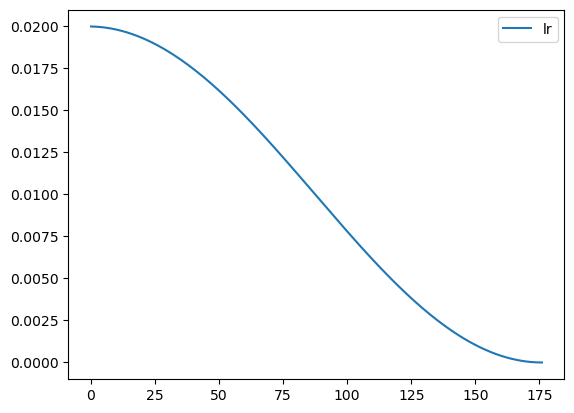

In [13]:
rec.plot()

Lets instead change only after each epoch

accuracy,loss,epoch,train
0.807,0.523,0,train
0.858,0.377,0,eval
0.880,0.327,1,train
0.869,0.338,1,eval
0.899,0.275,2,train
0.886,0.308,2,eval


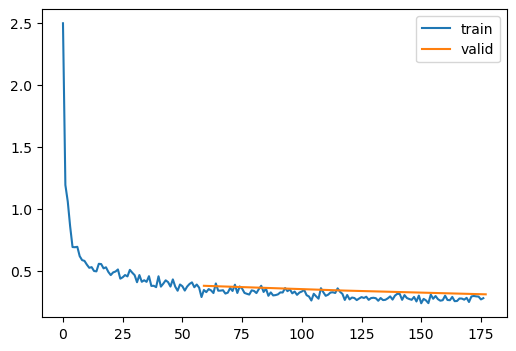

In [14]:
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3) # step at the end of each epock
set_seed(42)
xtra = [EpochSchedCB(sched),rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

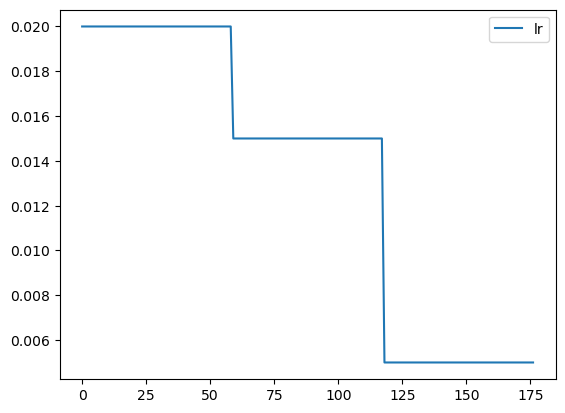

In [72]:
rec.plot()

### 1 cycle training

* was covered a bit in the first part of Fast AI.   See [paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.

* I honestly could not make heads or tails of his hand waving explanation of the 1 cycle training.  I will have to read the paper.


accuracy,loss,epoch,train
0.768,0.659,0,train
0.843,0.455,0,eval
0.857,0.388,1,train
0.862,0.398,1,eval
0.886,0.307,2,train
0.884,0.327,2,eval
0.907,0.249,3,train
0.897,0.278,3,eval
0.922,0.212,4,train
0.901,0.266,4,eval


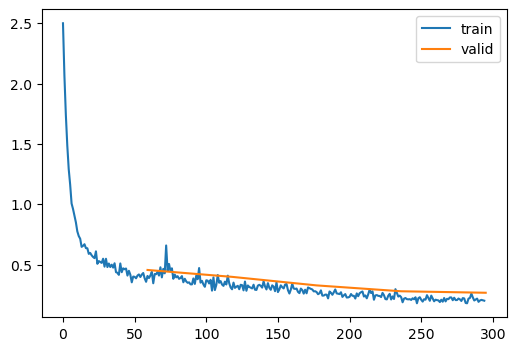

In [15]:
# record beta as well as lr 
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)


set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

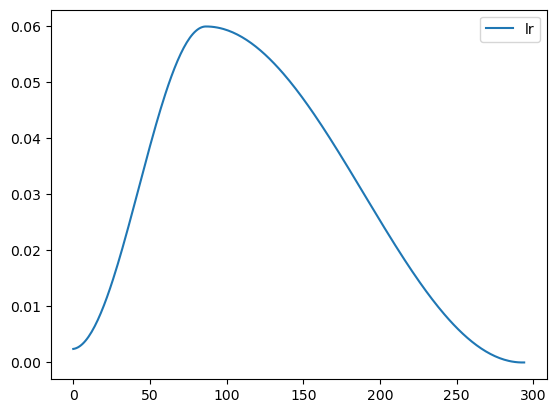

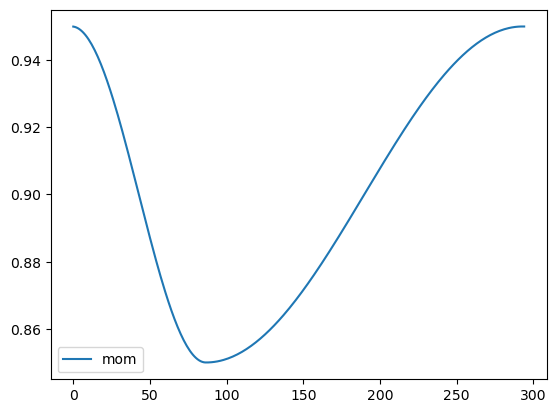

In [74]:
rec.plot()

## Changes to the previous notebooks / code
Note at this point he covers the change where they pass in the learner during the callback operation rather then saving the learner as an attribute in the callback object. We already did this since these changes were in the modified code we are using.  

Other changes:

* Added a callbacks parameter to Learner.fit to add extra callbacks.
* Added a learning rate paramter to fit to set the learning rate for one fit. 
* Added a two booleans to specify if you want to do the training, validation or both.
* Added a 'patch'  (@fc.patch) called 'lr_find' which was monkey patched into the learner class at the end of learner.py.  WHy do this instead of just adding it to the class?  Just trying to be clever? I don't know.

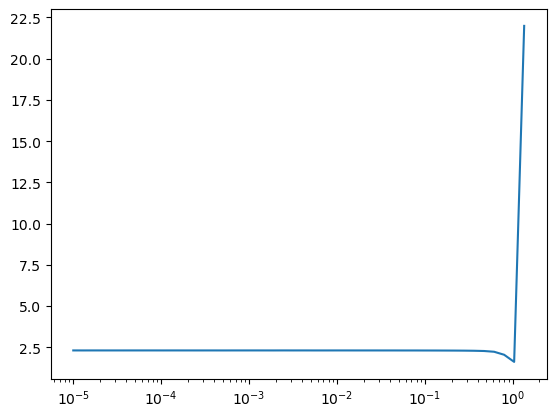

In [75]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs = cbs).lr_find()

Aside on monkey patching:

In [ ]:
Learner.poundsand = lambda self : print(f"Poundsand called on {id(self)}",self)
MomentumLearner(get_model(), dls, F.cross_entropy, cbs = cbs).poundsand()

## Resets

New Notebook from course [repo](https://github.com/fastai/course22p2) called 13_resnet.ipynb

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from minai.datasets import *
from minai.conv import *
from minai.learner import *
from minai.activations import *
from minai.init import *
from minai.sgd import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

# Get teh data back again

xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Set up metrics , activation function and callbacks.

In [3]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

Ok, first thing to try is just going deeper!

In [4]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=norm, bias=True), nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.806,0.700,0,train
0.843,0.482,0,eval
0.885,0.333,1,train
0.869,0.391,1,eval
0.909,0.257,2,train
0.898,0.294,2,eval
0.927,0.207,3,train
0.904,0.264,3,eval
0.943,0.163,4,train
0.924,0.222,4,eval


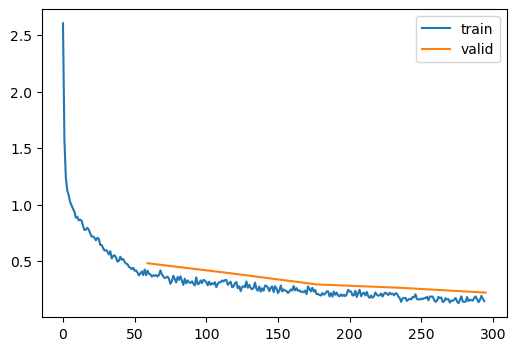

In [5]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

learn.fit(epochs)

Better already!  Up to 92%.    

### Skip connections

* Resnet paper : ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385).

* Going deeper eventually stops working well. For example they show a 56 layer network trains worse then a 20 layer network!  Must be a training issue.

*  One solution is to use skip connections to allow deeper leyers to learn from earlier layers (which are closer to the input). This allows the network to have a smaller network 'inside' it (following the skips). 

* Idea is to to use a block with two convs and a skip connection.  The skip connection is just the input added to the output of the block, something like this:
    
    ```
    x = self.conv(xin))
    x = self.conv(x)
    x += x_in # skip
    return F.relu(x)
    ```


* Called "residual" because the out - in is the residual which is what the block learns. 
* In typical case the out and in are not the same size, so you need to add a 'identity' conv to the skip connection to make them the same size.  

 

In [6]:

def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        # idconv, tries to be a simple as possible to reduce input to output size 
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()
    
    # here is the skip
    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))

def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)


Another use of patch. 

In [7]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
    def _f(hook, mod, inp, outp):
        nonlocal res,tot
        nparms = sum(o.numel() for o in mod.parameters())
        tot += nparms
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, train=False, cbs=SingleBatchCB())
    print("Tot params: ", tot)
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [8]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  1228908


|Module|Input|Output|Num params|
|--|--|--|--|
|ResBlock|(2048, 1, 28, 28)|(2048, 8, 28, 28)|712|
|ResBlock|(2048, 8, 28, 28)|(2048, 16, 14, 14)|3696|
|ResBlock|(2048, 16, 14, 14)|(2048, 32, 7, 7)|14560|
|ResBlock|(2048, 32, 7, 7)|(2048, 64, 4, 4)|57792|
|ResBlock|(2048, 64, 4, 4)|(2048, 128, 2, 2)|230272|
|ResBlock|(2048, 128, 2, 2)|(2048, 256, 1, 1)|919296|
|Flatten|(2048, 256, 1, 1)|(2048, 256)|0|
|Linear|(2048, 256)|(2048, 10)|2560|
|BatchNorm1d|(2048, 10)|(2048, 10)|20|


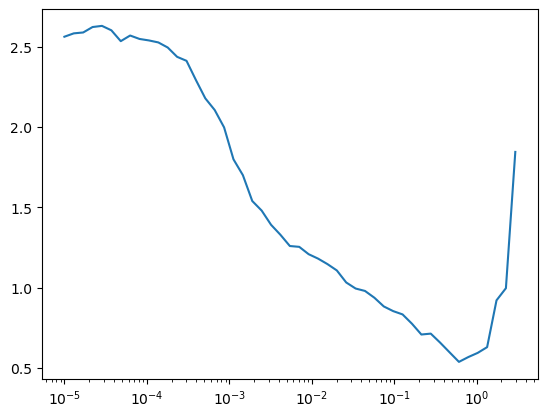

In [9]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
MomentumLearner(model, dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

accuracy,loss,epoch,train
0.819,0.704,0,train
0.860,0.508,0,eval
0.894,0.347,1,train
0.891,0.335,1,eval
0.917,0.251,2,train
0.886,0.341,2,eval
0.937,0.192,3,train
0.928,0.221,3,eval
0.954,0.142,4,train
0.931,0.212,4,eval


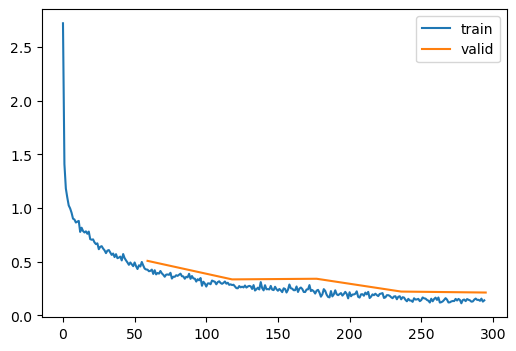

In [10]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

learn.fit(epochs)

93 percent!

At this point he goes through some examples using the "timm' library which has a lot of prebuilt image models.  I will skip this for now. Some insights:


* Contains many different resnet models.   

* Jeremy tried multiple resnet models from the library.  Best he found was Reset18d and he was able to get just over 92%, just a bit less then our model! 

* Encouraging that we can create good architecture just using common sense . 

## Data Augmentation 

Video at 1:23:56

* Yes we are *really* doing a third forking notebook in this lecture. 



In [1]:
import torch,random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from minai.datasets import *
from minai.conv import *
from minai.learner import *
from minai.activations import *
from minai.init import *
from minai.sgd import *
from minai.resnet import *

In [2]:
import pickle,gzip,math,os,time,shutil
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,optim
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

Setup for learning again

In [4]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

set_seed(42)
lr,epochs = 6e-2,5

### BUT FIRST, Going WIDER

* Increase the kernal size, and going to a 512 kernals in the last layer.   Marginally better.

* THen he removes the last layer to end up at 2x2 rather then 1x1, and do pooling to to 1x1.  This model is here:

(Global average pooling layer in tensor flow)

This is the going wider first version, not sure if we need it later.

In [5]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)


Set up our parameters for learning

In [6]:

lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]

In [7]:
class GlobalAvgPool(nn.Module):
    def forward(self, x): return x.mean((-2,-1))

def get_model2(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)



This is a change to summary but adds an estimate of Flops computed

In [8]:

def _flops(x, h, w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w

@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp,totf = 0,0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparms = sum(o.numel() for o in mod.parameters())
        totp += nparms
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
    print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [9]:
TrainLearner(get_model2(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 4907588; MFLOPS: 33.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3673600|14.7|
|GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5120|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.822,0.715,0,train
0.859,0.548,0,eval
0.897,0.384,1,train
0.879,0.389,1,eval
0.920,0.269,2,train
0.906,0.299,2,eval
0.939,0.200,3,train
0.924,0.244,3,eval
0.961,0.142,4,train
0.930,0.223,4,eval


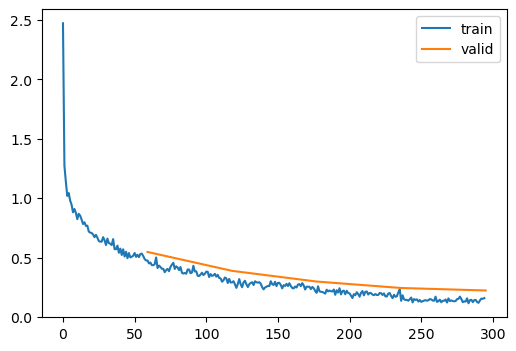

In [10]:
set_seed(42)
model = get_model2(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

At this point he introduces several variatinos of these models. 
Goals:
* Reduce flops - compute faster
* Reduce parameters - less memory

So he ablates the model, for example removing the last conv layer (the 512), which is 1/4 the size but same accuracy. 

To reduce compute, we need to do something with the first layer, which he does by replacing the first res block by just a single conv layer. THis doesnt reduce the parameters much but does reduce the computation, but still has about the same accuracy. 

In [11]:
def get_model4(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [conv(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [12]:
TrainLearner(get_model4(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1224948; MFLOPS: 13.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 16, 28, 28)|448|0.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.804,0.782,0,train
0.870,0.473,0,eval
0.898,0.392,1,train
0.894,0.356,1,eval
0.918,0.276,2,train
0.897,0.325,2,eval
0.940,0.202,3,train
0.924,0.241,3,eval
0.962,0.148,4,train
0.927,0.236,4,eval


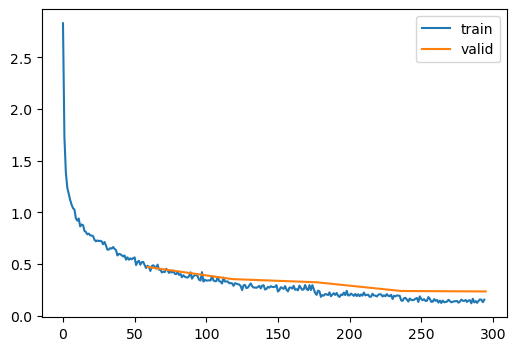

In [13]:
set_seed(42)
model = get_model4(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

So what if we train for longer?  He trains for gets 92.4 validation (with 99% training accuracy).  So it doesnt get better it starts memorizing.  We have to start *regularizing* the model.. 

Weight decay doesnt regularize at all if you use batch norm (it lets the network 'cheat' by changing the batch norm parameters to rescale the parameters).  So we need to use something else.

## Data Augmentation

* Change the images randomly so it doesnt see the same image all the time. 

* We will use the torchvision.transforms library to do this rather then implement from scratch  

* We covered a lot of this in Part 1

* We can use our BatchTransformCB to do this, but transforming the inputs and outputs

At 1:38 minutes into the video

In [16]:
from torchvision import transforms

def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                     transforms.RandomHorizontalFlip())

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[SingleBatchCB(), augcb])

In [15]:
BatchTransformCB??

Init signature: BatchTransformCB(tfm, on_train=True, on_val=True)
Docstring:      <no docstring>
Source:        
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)
File:           ~/datadev/pdl/minai/init.py
Type:           type
Subclasses:     

In [17]:
learn.fit(1)

And now we are going to monkey patch Learner to add a new method called show_image_batch...
By using the batch attribute of the learner we will see exactly what the model is looking at.

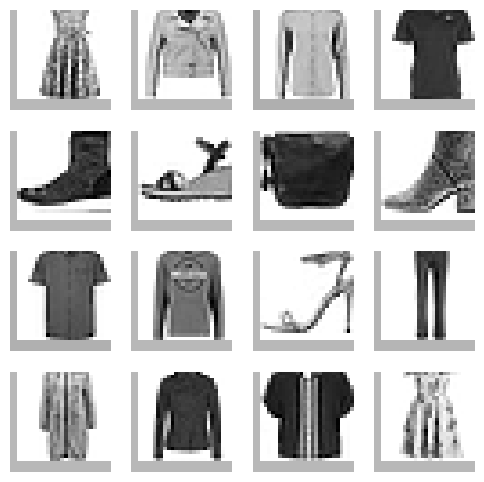

In [19]:
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Learner, max_n=9, cbs=None, **kwargs):
    self.fit(1, cbs=[SingleBatchCB()]+fc.L(cbs))
    show_images(self.batch[0][:max_n], **kwargs)


learn.show_image_batch(max_n=16, imsize=1.5)

* They all have the same transform (because we are using the batch callback) 
* This keeps all calcs on the gpu
* On the downside, a bit less variety.

accuracy,loss,epoch,train
0.764,0.878,0,train
0.824,0.600,0,eval
0.858,0.596,1,train
0.868,0.484,1,eval
0.878,0.477,2,train
0.864,0.459,2,eval
0.890,0.385,3,train
0.876,0.382,3,eval
0.893,0.342,4,train
0.882,0.376,4,eval


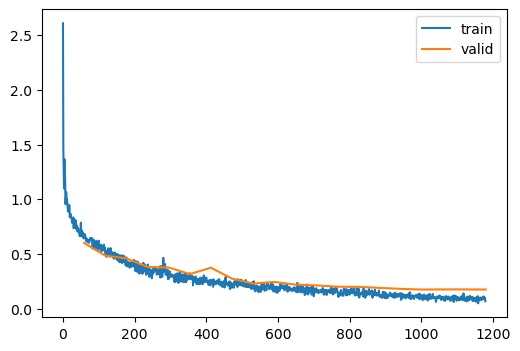

In [20]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Worth saving, we get: *94.3%* accuracy!  This is a big improvement.

In [22]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)
torch.save(learn.model, mdl_path/'data_aug.pkl')

### Test time agumentation

This does the augmentation at test time as well. 
* Makes the model more robust.
* ALso can average the predictions of the augmented images to get a better prediction (sort of like an ensemble).



We define a new callback to catpure the predictions and targets of the model and monkey patch the learner to make this easier to use.

In [21]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_inps,self.all_preds,self.all_targs = [],[],[]
    def after_batch(self, learn):
        self.all_inps. append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))
    def after_fit(self, learn):
        self.all_preds,self.all_targs,self.all_inps = map(torch.cat, [self.all_preds,self.all_targs,self.all_inps])

@fc.patch
def capture_preds(self: Learner, cbs=None, inps=False):
    cp = CapturePreds()
    self.fit(1, train=False, cbs=[cp]+fc.L(cbs))
    res = cp.all_preds,cp.all_targs
    if inps: res = res+(cp.all_inps,)
    return res


accuracy,loss,epoch,train
0.943,0.174,0,eval


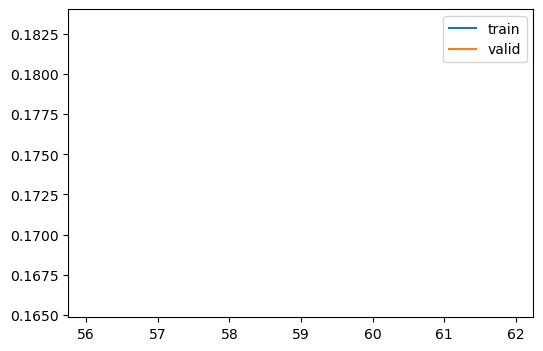

In [ ]:
ap1, at = learn.capture_preds();

accuracy,loss,epoch,train
0.942,0.175,0,eval


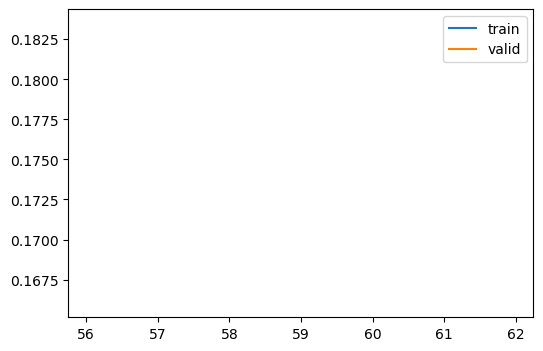

In [24]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

In [25]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
round((ap==at).float().mean().item(), 3)

0.945

94.5% accuracy without additional training.


### Random Erasing 

More augmentation. Randomly erase parts of the image.  Replace with random noise.

He creates a class to do this:

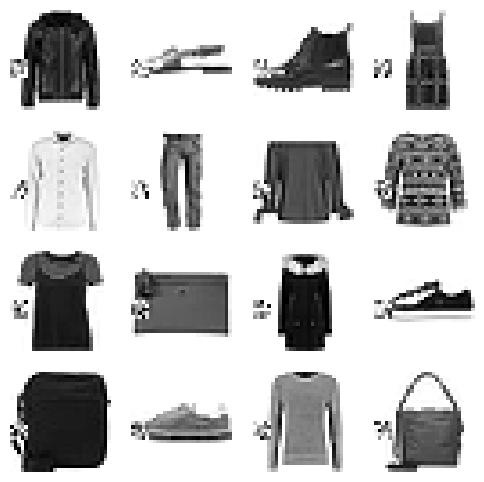

In [ ]:
def _rand_erase1(x, pct, xm, xs, mn, mx):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx = int(random.random()*(1-pct)*x.shape[-2])
    sty = int(random.random()*(1-pct)*x.shape[-1])
    init.normal_(x[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs)
    x.clamp_(mn, mx)

xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_erase1(xbt, 0.2, xbt.mean(), xbt.std(), xbt.min(), xbt.max())
show_images(xbt, imsize=1.5)

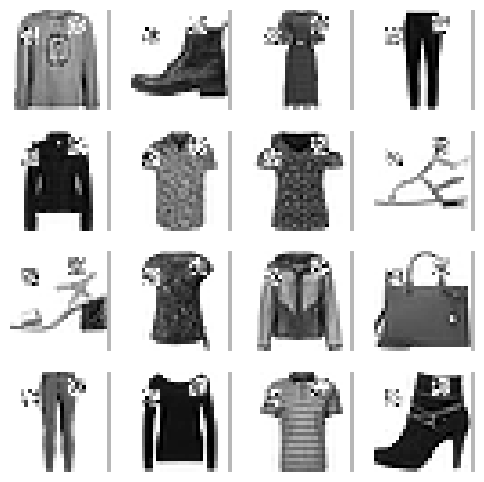

In [29]:

def rand_erase(x, pct=0.2, max_num = 4):
    xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
#     print(num)
    return x

class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)


tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

He trains this model and gets 94.9% , a bit better.

### Random copy

* Copy a patch from one part of the image to another. 

* Jeremy was not aware of anyone doing this .. but probably ther is someone.  

* Someone from chat suggests it is *similar* to 'cutmix'



accuracy,loss,epoch,train
0.738,0.944,0,train
0.813,0.604,0,eval
0.831,0.668,1,train
0.833,0.554,1,eval
0.850,0.568,2,train
0.823,0.527,2,eval
0.860,0.488,3,train
0.803,0.703,3,eval
0.873,0.411,4,train
0.827,0.508,4,eval


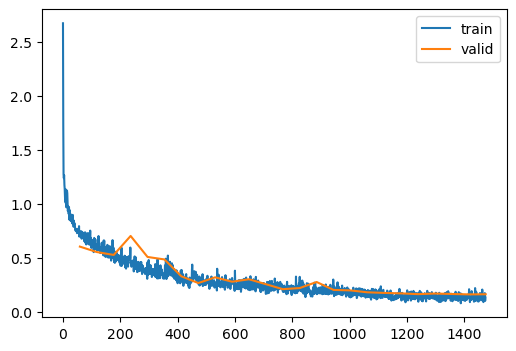

In [30]:
def _rand_copy1(x, pct):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx1 = int(random.random()*(1-pct)*x.shape[-2])
    sty1 = int(random.random()*(1-pct)*x.shape[-1])
    stx2 = int(random.random()*(1-pct)*x.shape[-2])
    sty2 = int(random.random()*(1-pct)*x.shape[-1])
    x[:,:,stx1:stx1+szx,sty1:sty1+szy] = x[:,:,stx2:stx2+szx,sty2:sty2+szy]


def rand_copy(x, pct=0.2, max_num = 4):
    num = random.randint(0, max_num)
    for i in range(num): _rand_copy1(x, pct)
#     print(num)
    return x

class RandCopy(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_copy(x, self.pct, self.max_num)

tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandCopy())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

set_seed(1)
epochs = 25
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

This one we did for onyl 25 epochs, because he wants to ensemble it with a second model, basically the same model but trained from different random weights.

accuracy,loss,epoch,train
0.738,0.941,0,train
0.811,0.645,0,eval
0.829,0.674,1,train
0.829,0.571,1,eval
0.847,0.578,2,train
0.831,0.536,2,eval
0.854,0.504,3,train
0.850,0.466,3,eval
0.870,0.417,4,train
0.836,0.500,4,eval


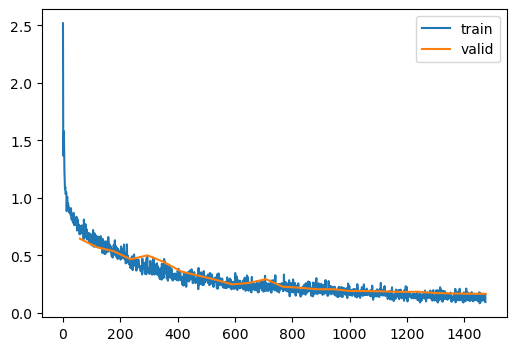

In [31]:
model2 = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn2 = TrainLearner(model2, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn2.fit(epochs)

Ensembling is good but not better then our best!

accuracy,loss,epoch,train
0.944,0.163,0,eval


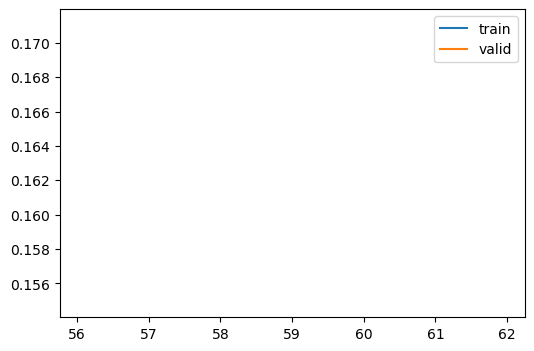

accuracy,loss,epoch,train
0.943,0.166,0,eval


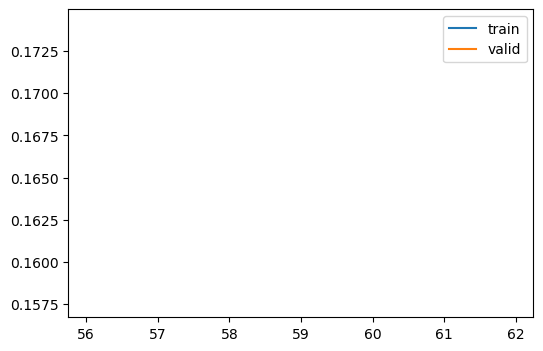

0.947

In [32]:
mdl_path = Path('models')
torch.save(learn.model,  mdl_path/'randcopy1.pkl')
torch.save(learn2.model, mdl_path/'randcopy2.pkl')

cp1 = CapturePreds()
learn.fit(1, train=False, cbs=cp1)
cp2 = CapturePreds()
learn2.fit(1, train=False, cbs=cp2)

ap = torch.stack([cp1.all_preds,cp2.all_preds]).mean(0).argmax(1)
round((ap==cp1.all_targs).float().mean().item(), 3)
